<a href="https://colab.research.google.com/github/samitha278/gpt-from-scratch/blob/main/GPT_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gdown
import random

In [ ]:
file_id = "1ia6z4itw7WJWpnoTohURX6Lm-AnZmVZz"
url = f"https://drive.google.com/uc?id={file_id}"

output = "input.txt"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ia6z4itw7WJWpnoTohURX6Lm-AnZmVZz
To: /content/input.txt
100%|██████████| 1.12M/1.12M [00:00<00:00, 9.67MB/s]


'input.txt'

In [ ]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

len(text)

1115394

In [ ]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [ ]:
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for i,s in enumerate(chars)}

encode = lambda s : [stoi[ch] for ch in s]
decode = lambda l : ''.join(itos[i] for i in l)

print(encode("Hello world"))
print(decode(encode("Hello world")))

[20, 43, 50, 50, 53, 1, 61, 53, 56, 50, 42]
Hello world


In [ ]:
data = torch.tensor(encode(text))
data[:100]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])

In [ ]:
n = int(0.9* len(data))
train = data[:n]
val = data[n:]

In [ ]:
block_size = 8

x = train[:block_size]
y = train[1:block_size+1]

for i in range(block_size):
  context = x[:i+1]
  target = y[i]

  print(f'{context} target:{target}')

tensor([18]) target:47
tensor([18, 47]) target:56
tensor([18, 47, 56]) target:57
tensor([18, 47, 56, 57]) target:58
tensor([18, 47, 56, 57, 58]) target:1
tensor([18, 47, 56, 57, 58,  1]) target:15
tensor([18, 47, 56, 57, 58,  1, 15]) target:47
tensor([18, 47, 56, 57, 58,  1, 15, 47]) target:58


In [ ]:
ix = torch.randint(100-block_size, (4,))
ix

tensor([57, 75, 26, 74])

In [ ]:
torch.manual_seed(278)


batch_size = 4
block_size = 8


def get_batch(split):

  data = train if split=='train' else val
  ix = torch.randint(len(data)-block_size, (batch_size,))
  x = torch.stack([data[i:block_size+i] for i in ix])
  y = torch.stack([data[i+1:block_size+i+1] for i in ix])
  return x,y


xb,yb = get_batch('train')

xb,yb

(tensor([[47, 57,  0, 42, 39, 59, 45, 46],
         [40, 59, 58,  1, 40, 39, 57, 58],
         [58, 53,  1, 46, 43, 56,  1, 57],
         [50, 63,  0, 58, 39, 56, 56, 63]]),
 tensor([[57,  0, 42, 39, 59, 45, 46, 58],
         [59, 58,  1, 40, 39, 57, 58, 39],
         [53,  1, 46, 43, 56,  1, 57, 53],
         [63,  0, 58, 39, 56, 56, 63,  1]]))

## Bigram Language Model

In [ ]:
torch.manual_seed(278)

class BigramLM(nn.Module):

  def __init__(self,vocab_size):
    super().__init__()

    self.token_emb_table = nn.Embedding(vocab_size,vocab_size)


  def __call__(self,idx , targets=None):

    logits = self.token_emb_table(idx)    #shape: (b,t,c)
    if targets is None:
      loss = None
    else:
      loss = F.cross_entropy(logits.view(-1,vocab_size) , targets.view(-1))

    return logits , loss


  def generate(self,idx, max_new_tokens):

    for _ in range(max_new_tokens):

      logits , loss = self(idx)

      logits = logits[:,-1,:] #from all batch's last element's logits

      probs = F.softmax(logits,dim=1)

      ix = torch.multinomial(probs,num_samples=1)

      idx = torch.cat((idx,ix), dim=1)

    return idx



bigram = BigramLM(vocab_size)
logits , loss = bigram(xb,yb)

print(logits.shape,loss)



idx= torch.zeros((1,1),dtype= torch.long)

print(decode(bigram.generate(idx,max_new_tokens=100)[0].tolist()))







torch.Size([4, 8, 65]) tensor(4.5468, grad_fn=<NllLossBackward0>)

hDkMQcyOQpP-rU-,VfVk:rXwxj Ug$$kNRxr.x'R3ULl!WC?fErPF'K'nybrlziq:IF:J.-YVN.jj$R-kDwR
hWiDAg,rHH'!JzL


In [ ]:
print([i.shape for i in bigram.parameters()])   #token_emb_table

[torch.Size([65, 65])]


In [ ]:
optimizer = torch.optim.AdamW(bigram.parameters(),lr = 1e-3)

In [ ]:
batch_size = 32

for i in range(1000):

  xb,yb = get_batch('train')

  logits , loss = bigram(xb,yb  )

  optimizer.zero_grad(set_to_none=True)

  loss.backward()

  optimizer.step()

  if i%10000 == 0:
    print(loss.item())


4.7092204093933105


In [ ]:
idx= torch.zeros((1,1),dtype= torch.long)

print(decode(bigram.generate(idx,max_new_tokens=100)[0].tolist()))


hW. U EQ&KHb
SKB3FKB&jq&p;JoYXMvlik:cusuILA:ivFrod3Y!
K?$ne FsT liO't JCoAHpEqKLKm!mLD3fMWArtawnJICl


### Averaging past context

In [ ]:
x,y = get_batch('train')
x[:4]

tensor([[49,  1, 46, 47, 57,  1, 45, 56],
        [ 1, 50, 47, 60, 43,  6,  0, 21],
        [61, 56, 39, 54,  1, 53, 59, 56],
        [46,  7,  7,  0,  0, 29, 33, 17]])

In [ ]:
xb,yb = bigram(x,y)
B,T,C = xb.shape
xb.shape

torch.Size([32, 8, 65])

In [ ]:
xbow = torch.zeros(xb.shape)

for b in range(B):
  for t in range(T):

    xprev = xb[b,:t+1]
    xbow[b,t] = xprev.mean(0)

### Averaging with matrix multiplication

In [ ]:
avg8 = torch.tensor([1/i for i in range(1,T+1)])
avg8

tensor([1.0000, 0.5000, 0.3333, 0.2500, 0.2000, 0.1667, 0.1429, 0.1250])

In [ ]:
avg88 = (avg8*torch.ones(T,T)).T

In [ ]:
avg88_tril = torch.tril(avg88)
avg88_tril

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [ ]:
a = torch.tril(torch.ones(T,T))
a = a / a.sum(1,keepdim=True)
a

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [ ]:
xbow_mat = torch.zeros(xb.shape)

for batch in range(B):
  xbow_mat[batch] = a @ xb[batch]


In [ ]:
xbow2 = a @ xb

In [ ]:
torch.allclose(xbow,xbow2)

False

### Summary of averaging

In [ ]:
a = torch.tril(torch.ones(T,T))
a = a / a.sum(1,keepdim=True)

xbow = a @ xb


### Version 3

In [ ]:
tril = torch.tril(torch.ones(T,T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril==0, float('-inf'))

wei = F.softmax(wei,dim = 1)

xbow3 = wei @ xb
(xbow3 == xbow2).all()

tensor(True)

### Version 4 - Self attention

In [ ]:
torch.manual_seed(278)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)


head_size = 16

key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)



k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
wei =  q @ k.transpose(-2, -1)

tril = torch.tril(torch.ones(T, T))

wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v

out.shape

torch.Size([4, 8, 16])

In [ ]:
k1 = torch.randint(20,(8,16))
q1 = torch.randint(20,(8,16))
q1 @ k1.T

tensor([[2207, 1825, 1972, 2191, 1443, 1603, 1861, 1726],
        [1803, 1803, 1540, 1247, 1334, 1368, 1510, 1474],
        [2062, 1867, 1510, 1463, 1350, 1605, 1576, 1113],
        [2460, 2033, 2103, 1838, 1646, 1975, 1993, 1439],
        [2238, 2017, 1827, 1520, 1592, 2044, 1740, 1312],
        [1968, 1718, 1644, 1577, 1226, 1635, 1436, 1127],
        [2198, 1941, 1831, 1410, 1704, 1656, 1783, 1584],
        [2163, 1772, 1826, 1560, 1523, 1418, 1789, 1328]])

### mat mul high dimension

In [ ]:
a = torch.randn((2,4,8))
b = torch.randn((2,4,4))
b @ a

tensor([[[-0.1080,  3.4493, -0.0389, -2.0157,  0.3596, -1.5135,  1.6457,
          -1.3712],
         [-1.0791, -0.5694, -0.1386,  2.9522,  0.5635,  0.4879, -1.8812,
           3.2153],
         [-1.7204, -0.5798,  0.2062,  0.4670,  0.4478, -0.1849, -0.1060,
           1.6224],
         [-2.2160,  4.4720,  0.0718, -1.4928,  1.2393, -2.3581,  1.6715,
           0.7310]],

        [[ 3.7422, -0.6046,  1.8760, -1.7515,  1.8201, -2.3911, -2.3626,
           0.6900],
         [ 3.2248,  0.7812,  2.1391, -0.6751,  1.5220, -2.4509, -3.0965,
           1.6815],
         [ 3.8133, -1.2514,  2.2410, -2.2957,  2.3149, -2.5146, -0.9141,
           0.3985],
         [ 2.1424, -1.9206,  4.1068, -1.7650,  2.1677, -1.9662,  5.3301,
           0.0766]]])

In [ ]:
xt,yt = get_batch('train')

xt.shape

torch.Size([32, 8])

In [ ]:
token_embd = nn.Embedding(65,40)
token_embd.weight.shape

out = token_embd(xt)
out.shape

torch.Size([32, 8, 40])

In [ ]:
lm_head = nn.Linear(40,65)
lm_head.weight.T.shape

torch.Size([40, 65])

In [ ]:
lm_head(out).shape

torch.Size([32, 8, 65])

## Step 2 Updated Bigram


In [ ]:
# hyperparameters
batch_size = 32
block_size = 64
eval_iters = 10000
n_embd = 128
head_size = n_embd
max_iter  = 10000
learning_rate = 1e-2

In [ ]:
class selfAttentionHead(nn.Module):


    def __init__(self,head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))


    def forward(self,x):

        B,T,C = x.shape

        key = self.key(x)
        query = self.query(x)

        weight = query @ key.transpose(-2,-1) * C**-0.5
        weight = weight.masked_fill(self.tril[:T,:T]==0,float('-inf'))
        weight = F.softmax(weight,dim=-1)

        value = self.value(x)

        self.out = weight @ value

        return self.out



class transformerDecoder(nn.Module):

    def __init__(self):
        super().__init__()

        self.embd_table = nn.Embedding(vocab_size,n_embd)
        self.pos_embd_table = nn.Embedding(block_size,n_embd)

        self.sa_head = selfAttentionHead(head_size)

        self.lm_head = nn.Linear(head_size,vocab_size)




    def forward(self,input, targets = None):

        B,T = input.shape

        token_embd = self.embd_table(input)
        pos_embd = self.pos_embd_table(torch.arange(T))

        x = token_embd+pos_embd
        x = self.sa_head(x)

        logits = self.lm_head(x)


        if targets is None:
            loss = None
        else:
            B,T,C = logits.shape
            loss = F.cross_entropy(logits.view(B*T,C),targets.view(-1))

        return logits , loss



    def generate(self,input,max_token):

        for _ in range(max_token):
            input_cond = input[:,-block_size:]
            logits , loss = self(input_cond)
            logits = logits[:,-1,:]

            probs = F.softmax(logits, dim=-1)
            next_index = torch.multinomial(probs,1)

            input = torch.cat((input,next_index),dim = 1)

        return input


    def train(self):

        # create a PyTorch optimizer
        optimizer = torch.optim.AdamW(self.parameters(), lr=learning_rate)

        for i in range(max_iter):

            xb,yb = get_batch('train')

            # evaluate model
            logits , loss = model(xb,yb)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()


            if i% (max_iter/10) == 0:
                print(f'{i}/{max_iter}  {loss}')



# ----------------------------------------------------------


# model evaluation
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out




# Train model
model = transformerDecoder()
#model.train()





# genarate from the model
# context = torch.zeros((1,1),dtype=torch.long)
# print(decode(model.generate(context,max_token=100)[0].tolist()))





In [ ]:
model.__dict__['_modules']

{'embd_table': Embedding(65, 128),
 'pos_embd_table': Embedding(8, 128),
 'sa_head': selfAttentionHead(
   (key): Linear(in_features=128, out_features=16, bias=False)
   (query): Linear(in_features=128, out_features=16, bias=False)
   (value): Linear(in_features=128, out_features=16, bias=False)
 ),
 'lm_head': Linear(in_features=16, out_features=65, bias=True)}

### test

In [ ]:
batch_size = 1
block_size = 8
eval_iters = 10000
n_embd = 128
head_size = 16
max_iter  = 10000
learning_rate = 1e-2

In [ ]:
input= torch.tensor([[53, 50, 43, 56, 10,  0, 25, 39]])
targets = torch.tensor([50, 43, 56, 10,  0, 25, 39, 42])

In [ ]:
simple_model = transformerDecoder()

In [ ]:
simple_model(input,targets)

(tensor([[[ 3.3355e-01,  6.8891e-01, -8.3918e-01,  1.0558e+00, -6.4635e-01,
            7.8033e-01,  5.4743e-01,  1.2486e-01, -6.3534e-02,  1.5087e-01,
            5.5966e-01, -7.2753e-02, -1.9249e-01,  1.4256e-01, -4.9183e-03,
           -6.4516e-01,  9.2371e-02, -5.7139e-01, -7.9722e-01, -2.4662e-01,
           -4.1347e-01,  3.2933e-01,  7.5681e-01, -6.5150e-01, -1.5127e-01,
            3.0669e-01, -2.5543e-01, -4.1121e-01, -1.9136e-01, -2.4008e-01,
            8.5032e-02, -3.7000e-01,  3.8740e-01,  1.0096e-02, -1.9931e-01,
           -1.3735e-02, -1.0452e-01, -2.8312e-01, -3.9280e-01,  4.1761e-01,
           -1.1185e-01, -9.2053e-01,  3.0232e-01,  2.2996e-01,  1.1474e-01,
            7.1255e-01, -3.1004e-01, -2.5723e-01,  5.8349e-02, -3.9239e-01,
            1.0397e+00, -4.0278e-01,  8.5969e-01,  7.7121e-01, -6.2261e-01,
           -8.6065e-01, -4.7702e-01, -1.0585e-01,  8.5334e-02, -7.1318e-01,
            6.1245e-02, -1.5040e-01,  4.3655e-01, -6.4171e-01,  3.8137e-03],
          [

In [ ]:
head1 = selfAttentionHead(16)

In [ ]:
input = torch.randn((batch_size,block_size,n_embd))    #(1,8,32)

In [ ]:
att_out = head1(input)

In [ ]:
att_out.shape

torch.Size([1, 8, 16])

# GPT test

In [ ]:

#hyperparameters
block_size = 8
batch_size = 32
n_embd = 64
num_heads = 4
head_size = n_embd // num_heads
eval_iter = 10000
max_iter = 10000
lr = 1e-3



# #text read
# with open('data/input.txt', 'r') as f:
#     text = f.read()


#get characters from input.txt
chars = sorted(list(set(text)))
vocab_size = len(chars)


#encoding and decoding
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for i,s in enumerate(chars)}

encode = lambda s: [stoi[ch] for ch in s]
decode = lambda l: ''.join([itos[i] for i in l])



# encode text
data = encode(text)

# train / val split
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]



# create mini batch
def get_batch(split):

    data = train_data if split=='train' else val_data

    idx = torch.randint(len(data)-block_size , (block_size,))

    x = torch.tensor([data[i:i+block_size] for i in idx])
    y = torch.tensor([data[i+1:block_size+1+i] for i in idx])

    return x,y




# -------------------------------------------------------------


class SaHead(nn.Module):


    def __init__(self,head_size):
        super().__init__()

        self.key = nn.Linear(n_embd,head_size, bias = False)
        self.query = nn.Linear(n_embd,head_size,bias = False)

        self.value = nn.Linear(n_embd,head_size, bias = False)

        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))


    def forward(self,x):

        B,T,C = x.shape

        key = self.key(x)
        query = self.query(x)

        weight = query @ key.transpose(-2,-1) * C**-0.5
        weight = weight.masked_fill(self.tril[:T,:T]==0,float('-inf'))
        weight = F.softmax(weight,dim=-1)

        value = self.value(x)

        out = weight @ value

        return out


class MultiHead(nn.Module):

    def __init__(self, num_heads,head_size):
        super().__init__()

        self.sa_heads = nn.ModuleList([SaHead(head_size) for i in range(num_heads)])
        self.projection = nn.Linear(num_heads * head_size , n_embd)



    def forward(self,x):
        out = torch.cat([sa(x) for sa in self.sa_heads],dim = -1)

        out = self.projection(out)

        return out




class MLP(nn.Module):

    def __init__(self,n_embd):
        super().__init__()

        self.mlp = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd,n_embd) # projection
        )

    def forward(self,x):

        return self.mlp(x)




class Block(nn.Module):

    def __init__(self,num_heads,n_embd):
        super().__init__()

        head_size = n_embd // num_heads

        self.heads = MultiHead(num_heads,head_size)
        self.mlp = MLP(n_embd)
        self.layer_norm1 = nn.LayerNorm(n_embd)
        self.layer_norm2 = nn.LayerNorm(n_embd)


    def forward(self,x):

        # added pre layerNorms
        out = self.heads(self.layer_norm1(x)) + x  # residual conn
        out = self.mlp(self.layer_norm2(out)) + out  # residual conn

        return out







class GPTModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.embd_table = nn.Embedding(vocab_size,n_embd)
        self.pos_embd_table = nn.Embedding(block_size,n_embd)

        self.block = nn.Sequential(
            Block(num_heads,n_embd),
            Block(num_heads,n_embd),
            Block(num_heads,n_embd),
            nn.LayerNorm(n_embd)
        )

        self.lm_head = nn.Linear(n_embd,vocab_size)




    def forward(self,input, targets = None):

        B,T = input.shape

        token_embd = self.embd_table(input)
        pos_embd = self.pos_embd_table(torch.arange(T))

        x = token_embd+pos_embd

        x = self.block(x)

        logits = self.lm_head(x)


        if targets is None:
            loss = None
        else:
            B,T,C = logits.shape
            loss = F.cross_entropy(logits.view(B*T,C),targets.view(-1))

        return logits , loss





    def train(self):

        # create a PyTorch optimizer
        optimizer = torch.optim.AdamW(self.parameters(), lr=lr)

        for i in range(max_iter):

            xb,yb = get_batch('train')

            # evaluate model
            logits , loss = self(xb,yb)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()


            if i% (max_iter/10) == 0:
                print(f'{i}/{max_iter}  {loss}')
            if i == max_iter-1:
                print(f'{max_iter}/{max_iter}  {loss}')






    def generate(self,input,max_token):

        for _ in range(max_token):
            input_cond = input[:,-block_size:]
            logits , loss = self(input_cond)
            logits = logits[:,-1,:]

            probs = F.softmax(logits, dim=-1)
            next_index = torch.multinomial(probs,1)

            input = torch.cat((input,next_index),dim = 1)

        return input



# ----------------------------------------------------------



model = GPTModel()
model.train()



# genarate from the model
context = torch.zeros((1,1),dtype=torch.long)
print(decode(model.generate(context,max_token=100)[0].tolist()))

0/10000  4.419777870178223
1000/10000  2.17536997795105
2000/10000  2.062408685684204
3000/10000  2.344139337539673
4000/10000  1.889953851699829
5000/10000  2.36834979057312
6000/10000  2.168095111846924
7000/10000  1.7695579528808594
8000/10000  2.1250112056732178
9000/10000  2.0149948596954346
10000/10000  2.1397757530212402

Or conwlarga.

LAY I blood tcrain. Belioustil all of that wors, contial of the sance,
I we Vather, i


In [ ]:
context = torch.zeros((1,1),dtype=torch.long)
print(decode(model.generate(context,max_token=100)[0].tolist()))


Then thither presilme,
Shalk; Monatons in the diss, hiner-ver bite,
Master, inten that sene a centio


### Post norm block

In [ ]:
class Block(nn.Module):

    def __init__(self,num_heads,n_embd):
        super().__init__()

        head_size = n_embd // num_heads

        self.heads = MultiHead(num_heads,head_size)
        self.mlp = MLP(n_embd)
        self.layer_norm1 = nn.LayerNorm(n_embd)
        self.layer_norm2 = nn.LayerNorm(n_embd)


    def forward(self,x):

        # added pre layerNorms
        out = self.layer_norm1(self.heads(x)) + x  # residual conn
        out = self.layer_norm2(self.mlp(out)) + out  # residual conn

        return out

### Dropout

In [ ]:
m = nn.Dropout(p=0.2)
input = torch.randn(20, 16)
output = m(input)

In [ ]:
input[:2], output[:2]

(tensor([[-0.6299,  0.1383, -1.1998,  1.5261, -1.9696,  0.2256, -1.5972,  0.9552,
          -1.0033,  2.4680, -1.7472,  0.8085, -0.3762, -0.3624, -0.6486, -0.2558],
         [ 0.2277, -0.2409, -1.7033, -1.6424, -0.4022, -1.0217, -0.0447, -1.7052,
           0.2181,  0.6675,  1.1619,  0.8225,  1.4728, -0.2752,  1.5735,  0.0059]]),
 tensor([[-0.7873,  0.1729, -1.4997,  1.9076, -2.4620,  0.2821, -0.0000,  1.1940,
          -1.2541,  0.0000, -2.1840,  0.0000, -0.4702, -0.0000, -0.8108, -0.3197],
         [ 0.2846, -0.3011, -0.0000, -2.0530, -0.5028, -1.2771, -0.0559, -2.1315,
           0.2727,  0.8343,  1.4524,  1.0282,  1.8410, -0.3440,  1.9669,  0.0073]]))

## Add dropout to gpt

In [ ]:

#hyperparameters
block_size = 32
batch_size = 64
n_embd = 128
num_heads = 4
num_blocks = 6
head_size = n_embd // num_heads
eval_iter = 10000
max_iter = 10000
lr = 1e-4
dropout = 0.16



# #text read
# with open('data/input.txt', 'r') as f:
#     text = f.read()


#get characters from input.txt
chars = sorted(list(set(text)))
vocab_size = len(chars)


#encoding and decoding
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for i,s in enumerate(chars)}

encode = lambda s: [stoi[ch] for ch in s]
decode = lambda l: ''.join([itos[i] for i in l])



# encode text
data = encode(text)

# train / val split
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]



# create mini batch
def get_batch(split):

    data = train_data if split=='train' else val_data

    idx = torch.randint(len(data)-block_size , (block_size,))

    x = torch.tensor([data[i:i+block_size] for i in idx])
    y = torch.tensor([data[i+1:block_size+1+i] for i in idx])

    return x,y




# -------------------------------------------------------------


class SaHead(nn.Module):


    def __init__(self,head_size):
        super().__init__()

        self.key = nn.Linear(n_embd,head_size, bias = False)
        self.query = nn.Linear(n_embd,head_size,bias = False)

        self.value = nn.Linear(n_embd,head_size, bias = False)

        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)


    def forward(self,x):

        B,T,C = x.shape

        key = self.key(x)
        query = self.query(x)

        weight = query @ key.transpose(-2,-1) * C**-0.5
        weight = weight.masked_fill(self.tril[:T,:T]==0,float('-inf'))
        weight = F.softmax(weight,dim=-1)


        weight = self.dropout(weight)
        value = self.value(x)

        out = weight @ value



        return out


class MultiHead(nn.Module):

    def __init__(self, num_heads,head_size):
        super().__init__()

        self.sa_heads = nn.ModuleList([SaHead(head_size) for i in range(num_heads)])
        self.projection = nn.Linear(num_heads * head_size , n_embd)

        self.dropout = nn.Dropout(dropout)



    def forward(self,x):
        out = torch.cat([sa(x) for sa in self.sa_heads],dim = -1)

        out = self.projection(out)

        out = self.dropout(out)

        return out




class MLP(nn.Module):

    def __init__(self,n_embd):
        super().__init__()

        self.mlp = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd,n_embd), # projection
            nn.Dropout(dropout)
        )


    def forward(self,x):

        out = self.mlp(x)
        return out







class Block(nn.Module):

    def __init__(self,num_heads,n_embd):
        super().__init__()

        head_size = n_embd // num_heads

        self.heads = MultiHead(num_heads,head_size)
        self.mlp = MLP(n_embd)
        self.layer_norm1 = nn.LayerNorm(n_embd)
        self.layer_norm2 = nn.LayerNorm(n_embd)

        self.dropout = nn.Dropout(dropout)


    def forward(self,x):

        # added pre layerNorms
        out = self.heads(self.layer_norm1(x)) + x  # residual conn
        out = self.mlp(self.layer_norm2(out)) + out  # residual conn


        out = self.dropout(out)

        return out







class GPTModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.embd_table = nn.Embedding(vocab_size,n_embd)
        self.pos_embd_table = nn.Embedding(block_size,n_embd)

        self.block = nn.Sequential(*[Block(num_heads,n_embd) for i in range(num_blocks)])
        self.ln = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd,vocab_size)




    def forward(self,input, targets = None):

        B,T = input.shape

        token_embd = self.embd_table(input)
        pos_embd = self.pos_embd_table(torch.arange(T))

        x = token_embd+pos_embd

        x = self.block(x)
        x = self.ln(x)
        logits = self.lm_head(x)


        if targets is None:
            loss = None
        else:
            B,T,C = logits.shape
            loss = F.cross_entropy(logits.view(B*T,C),targets.view(-1))

        return logits , loss





    def train(self):

        # create a PyTorch optimizer
        optimizer = torch.optim.AdamW(self.parameters(), lr=lr)

        losses = torch.zeros(max_iter)

        for i in range(max_iter):

            xb,yb = get_batch('train')

            # evaluate model
            logits , loss = self(xb,yb)

            losses[i] = loss

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()


            if i% (max_iter/10) == 0:
                print(f'{i}/{max_iter}  {loss}')
            if i == max_iter-1:
                print(f'{max_iter}/{max_iter}  {loss}')


        return losses






    def generate(self,input,max_token):

        for _ in range(max_token):
            input_cond = input[:,-block_size:]
            logits , loss = self(input_cond)
            logits = logits[:,-1,:]

            probs = F.softmax(logits, dim=-1)
            next_index = torch.multinomial(probs,1)

            input = torch.cat((input,next_index),dim = 1)

        return input



# ----------------------------------------------------------



model = GPTModel()
#losses = model.train()



# genarate from the model
context = torch.zeros((1,1),dtype=torch.long)
print(decode(model.generate(context,max_token=100)[0].tolist()))


T.:tqam ;
TLT HubnbWsFCa'kJi OyH;d-iRFbxCZ;omRGHp.P.-EFZNxqCRjIf.itEK&,3IBOypj.TC.zPeD HIAsMXXHEOhwo


In [ ]:
print(sum([p.numel() for p in model.parameters()]))

1208385


# gpt on GPU

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#hyperparameters
block_size = 32
batch_size = 64
n_embd = 128
num_heads = 4
num_blocks = 6
head_size = n_embd // num_heads
eval_iter = 10000
max_iter = 10000
lr = 1e-4
dropout = 0.16



# #text read
# with open('data/input.txt', 'r') as f:
#     text = f.read()


#get characters from input.txt
chars = sorted(list(set(text)))
vocab_size = len(chars)


#encoding and decoding
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for i,s in enumerate(chars)}

encode = lambda s: [stoi[ch] for ch in s]
decode = lambda l: ''.join([itos[i] for i in l])



# encode text
data = encode(text)

# train / val split
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]



# create mini batch
def get_batch(split):

    data = train_data if split=='train' else val_data

    idx = torch.randint(len(data)-block_size , (block_size,))

    x = torch.tensor([data[i:i+block_size] for i in idx])
    y = torch.tensor([data[i+1:block_size+1+i] for i in idx])

    x, y = x.to(device), y.to(device)

    return x,y




# -------------------------------------------------------------


class SaHead(nn.Module):


    def __init__(self,head_size):
        super().__init__()

        self.key = nn.Linear(n_embd,head_size, bias = False)
        self.query = nn.Linear(n_embd,head_size,bias = False)

        self.value = nn.Linear(n_embd,head_size, bias = False)

        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)


    def forward(self,x):

        B,T,C = x.shape

        key = self.key(x)
        query = self.query(x)

        weight = query @ key.transpose(-2,-1) * C**-0.5
        weight = weight.masked_fill(self.tril[:T,:T]==0,float('-inf'))
        weight = F.softmax(weight,dim=-1)


        weight = self.dropout(weight)
        value = self.value(x)

        out = weight @ value



        return out


class MultiHead(nn.Module):

    def __init__(self, num_heads,head_size):
        super().__init__()

        self.sa_heads = nn.ModuleList([SaHead(head_size) for i in range(num_heads)])
        self.projection = nn.Linear(num_heads * head_size , n_embd)

        self.dropout = nn.Dropout(dropout)



    def forward(self,x):
        out = torch.cat([sa(x) for sa in self.sa_heads],dim = -1)

        out = self.projection(out)

        out = self.dropout(out)

        return out




class MLP(nn.Module):

    def __init__(self,n_embd):
        super().__init__()

        self.mlp = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd,n_embd), # projection
            nn.Dropout(dropout)
        )


    def forward(self,x):

        out = self.mlp(x)
        return out







class Block(nn.Module):

    def __init__(self,num_heads,n_embd):
        super().__init__()

        head_size = n_embd // num_heads

        self.heads = MultiHead(num_heads,head_size)
        self.mlp = MLP(n_embd)
        self.layer_norm1 = nn.LayerNorm(n_embd)
        self.layer_norm2 = nn.LayerNorm(n_embd)

        self.dropout = nn.Dropout(dropout)


    def forward(self,x):

        # added pre layerNorms
        out = self.heads(self.layer_norm1(x)) + x  # residual conn
        out = self.mlp(self.layer_norm2(out)) + out  # residual conn


        out = self.dropout(out)

        return out







class GPTModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.embd_table = nn.Embedding(vocab_size,n_embd)
        self.pos_embd_table = nn.Embedding(block_size,n_embd)

        self.block = nn.Sequential(*[Block(num_heads,n_embd) for i in range(num_blocks)])
        self.ln = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd,vocab_size)




    def forward(self,input, targets = None):

        B,T = input.shape

        token_embd = self.embd_table(input)
        pos_embd = self.pos_embd_table(torch.arange(T, device=device))

        x = token_embd+pos_embd

        x = self.block(x)
        x = self.ln(x)
        logits = self.lm_head(x)


        if targets is None:
            loss = None
        else:
            B,T,C = logits.shape
            loss = F.cross_entropy(logits.view(B*T,C),targets.view(-1))

        return logits , loss





    def train(self):

        # create a PyTorch optimizer
        optimizer = torch.optim.AdamW(self.parameters(), lr=lr)

        losses = torch.zeros(max_iter)

        for i in range(max_iter):

            xb,yb = get_batch('train')

            # evaluate model
            logits , loss = self(xb,yb)

            losses[i] = loss

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()


            if i% (max_iter/10) == 0:
                print(f'{i}/{max_iter}  {loss}')
            if i == max_iter-1:
                print(f'{max_iter}/{max_iter}  {loss}')


        return losses






    def generate(self,input,max_token):

        for _ in range(max_token):
            input_cond = input[:,-block_size:]
            logits , loss = self(input_cond)
            logits = logits[:,-1,:]

            probs = F.softmax(logits, dim=-1)
            next_index = torch.multinomial(probs,1)

            input = torch.cat((input,next_index),dim = 1)

        return input



# ----------------------------------------------------------



model = GPTModel()
model = model.to(device)
losses = model.train()



# genarate from the model
context = torch.zeros((1,1),dtype=torch.long,device=device)
print(decode(model.generate(context,max_token=100)[0].tolist()))

0/10000  4.360275745391846
1000/10000  2.4701366424560547
2000/10000  2.394174814224243
3000/10000  2.253653049468994
4000/10000  2.2769970893859863
5000/10000  2.2080271244049072
6000/10000  2.155518054962158
7000/10000  2.076859951019287
8000/10000  2.0508880615234375
9000/10000  2.046293258666992
10000/10000  2.072751760482788

Far you.

DUCKE?
SIO:
Shat so bolich he is sort com of it a lam haplame
Lard ray:
A Gode callerZy a'


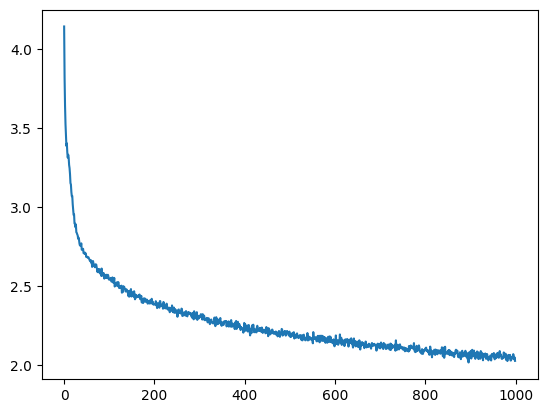

In [ ]:
plt.plot(losses.view(-1,10).mean(1).tolist())

In [ ]:
print(sum([p.numel() for p in model.parameters()]))

1208385
